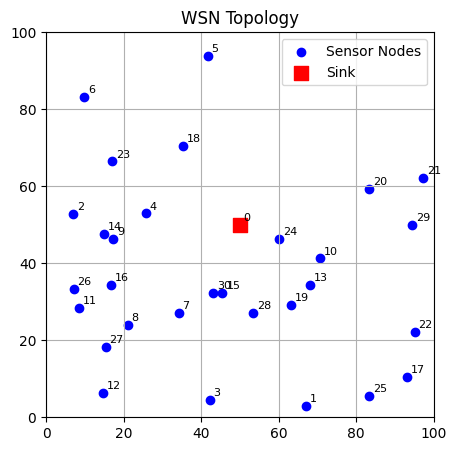

Optimasi Neural Network dengan EGWO


Optimasi selesai.
Waktu yang dibutuhkan: 1229.28 detik
Best Fitness (nilai negatif rata-rata node hidup): -26.0360

Parameter NN terbaik (EGWO-NN):
Param 1: 0.1119
Param 2: 0.0664
Param 3: -0.9592
Param 4: 0.8639
Param 5: 0.5458
Param 6: 0.0266
Param 7: 0.9978
Param 8: 0.0053
Param 9: -0.3368
Param 10: 0.1197
Param 11: -1.0000
Param 12: 0.8101

Contoh hasil simulasi (10 round pertama):
Round	Alive	CH_Count
0	30	9
1	30	9
2	30	9
3	30	8
4	30	8
5	30	8
6	30	8
7	30	8
8	30	8
9	30	7


In [1]:
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt

# =========================================
# PARAMETER UTAMA (disesuaikan)
# =========================================
NUM_NODES   = 30
FIELD_SIZE  = (100, 100)
SINK_POS    = (50, 50)

INITIAL_ENERGY = 2.0      # 2 Joule
NUM_ROUNDS     = 2000

# Model Radio
E_ELEC     = 50e-9        # 50 nJ/bit
E_AMP      = 5e-9         # 5 nJ/bit/m^2
PACKET_SIZE= 6000         # bit

# Overhead khusus
LEACH_CH_OVERHEAD  = 0.001   # overhead bagi CH per round
PEGASIS_LEADER_OVH = 0.003   # overhead bagi leader di PEGASIS
GA_NN_CH_OVERHEAD  = 0.002   # overhead bagi node "CH" di GA-NN

# Threshold untuk menentukan CH (sesuai dengan GA-NN)
CH_THRESHOLD = -0.6

# =========================================
# Fungsi Utilitas dan Model Radio
# =========================================
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def tx_energy(dist):
    # Energi untuk transmisi: paket * (E_ELEC + E_AMP * (dist^2))
    return PACKET_SIZE * (E_ELEC + E_AMP * (dist**2))

def rx_energy():
    # Energi untuk penerimaan data
    return PACKET_SIZE * E_ELEC

def random_positions(num, size_):
    return [(random.uniform(0,size_[0]), random.uniform(0,size_[1])) for _ in range(num)]


# =========================================
# TOPOLOGI
#  node[0] = sink, node[1..NUM_NODES] = sensor
# =========================================
positions = [SINK_POS] + random_positions(NUM_NODES, FIELD_SIZE)

def plot_topology():
    plt.figure(figsize=(5,5))
    xs = [p[0] for p in positions]
    ys = [p[1] for p in positions]
    plt.scatter(xs[1:], ys[1:], label='Sensor Nodes', c='blue')
    plt.scatter(xs[0], ys[0], label='Sink', c='red', marker='s', s=100)
    for i, (x, y) in enumerate(positions):
        plt.text(x+1, y+1, str(i), fontsize=8)
    plt.title("WSN Topology")
    plt.xlim(0, FIELD_SIZE[0])
    plt.ylim(0, FIELD_SIZE[1])
    plt.grid(True)
    plt.legend()
    plt.show()

plot_topology()

#==========================================
# =========================================
# 1. LEACH
# =========================================
def simulate_leach():
    """
    Tambahan: catat jumlah CH setiap round di 'ch_count_list'
    """
    p = 0.1
    energy = [INITIAL_ENERGY]*(NUM_NODES+1)
    energy[0] = float('inf')  # sink
    alive_list = []
    ch_count_list = []  # untuk simpan jumlah CH tiap round

    for r in range(NUM_ROUNDS):
        alive_nodes = [i for i in range(1, NUM_NODES+1) if energy[i]>0]
        if not alive_nodes:
            # jika tidak ada node hidup
            alive_list.append(0)
            ch_count_list.append(0)
            continue

        # Fase setup: probabilitas p
        is_CH = [False]*(NUM_NODES+1)
        for i in alive_nodes:
            if random.random() < p:
                is_CH[i] = True

        # jika tidak ada CH, pilih 1 node hidup secara random
        if not any(is_CH[i] for i in alive_nodes):
            chosen = random.choice(alive_nodes)
            is_CH[chosen] = True

        # Fase steady
        for i in alive_nodes:
            if is_CH[i]:
                # overhead CH
                if energy[i] > LEACH_CH_OVERHEAD:
                    energy[i] -= LEACH_CH_OVERHEAD
                else:
                    energy[i] = 0
                    continue

                # kirim ke sink
                d_sink = distance(positions[i], positions[0])
                cost_tx = tx_energy(d_sink)
                if energy[i] > cost_tx:
                    energy[i] -= cost_tx
                else:
                    energy[i] = 0
            else:
                # kirim ke CH terdekat
                ch_list = [ch for ch in alive_nodes if is_CH[ch] and ch!=i]
                if ch_list:
                    dists = [distance(positions[i], positions[ch]) for ch in ch_list]
                    idx = np.argmin(dists)
                    chosen_ch = ch_list[idx]
                    dist_ = dists[idx]
                    cost_tx = tx_energy(dist_)
                    cost_rx_ = rx_energy()
                    if energy[i]>cost_tx and energy[chosen_ch]>cost_rx_:
                        energy[i] -= cost_tx
                        energy[chosen_ch] -= cost_rx_

        # catat jumlah node hidup dan jumlah CH di round ini
        alive_list.append(len([e for e in energy[1:] if e>0]))
        ch_count_list.append(sum(1 for i in alive_nodes if is_CH[i]))

    while len(alive_list)<NUM_ROUNDS:
        alive_list.append(0)
    while len(ch_count_list)<NUM_ROUNDS:
        ch_count_list.append(0)

    return {
        'round': list(range(NUM_ROUNDS)),
        'alive': alive_list,
        'ch_count': ch_count_list  # <--- tambahan
    }


# =========================================
# 2. PEGASIS
# =========================================
#   - Buat chain
#   - Leader bergantian
#   - Leader overhead PEGASIS_LEADER_OVH
#   - re chain
# =========================================
# ==== PARAMETER TAMBAHAN UNTUK RE-CHAIN ====
RECHAIN_INTERVAL = 50           # Misal setiap 50 round
PEGASIS_RECHAIN_OVH = 0.001     # Overhead re-chain

# === Fungsi bantu: membentuk rantai berdasarkan node hidup ===
def build_chain_pegasis_dynamic(alive_nodes, positions):
    """
    Membuat chain PEGASIS secara 'greedy nearest'
    hanya untuk node-node yang masih hidup (alive_nodes).
    """
    if not alive_nodes:
        return []
    # Salin list, urutkan sekadar memudahkan
    # (opsional, agar sequence reproducible)
    unused = alive_nodes[:]
    chain = []
    current = unused.pop(0)
    chain.append(current)
    while unused:
        dists = [(n, distance(positions[current], positions[n])) for n in unused]
        nxt, _ = min(dists, key=lambda x: x[1])
        chain.append(nxt)
        unused.remove(nxt)
        current = nxt
    return chain

def simulate_pegasis_rechain():
    """
    PEGASIS dengan overhead re-chain.
    - Rantai akan dibentuk ulang setiap RECHAIN_INTERVAL round,
      atau saat jumlah node hidup berubah (karena ada node mati).
    - Overhead re-chain dibebankan ke node hidup (PEGASIS_RECHAIN_OVH).
    """
    energy = [INITIAL_ENERGY]*(NUM_NODES+1)
    energy[0] = float('inf')  # sink
    alive_history = []

    # Inisialisasi chain pertama
    all_alive_nodes = list(range(1, NUM_NODES+1))
    current_chain = build_chain_pegasis_dynamic(all_alive_nodes, positions)
    chain_len = len(current_chain)

    prev_alive_count = NUM_NODES  # jumlah node hidup di round sebelumnya

    for r in range(NUM_ROUNDS):
        # Cari node hidup saat ini
        alive_nodes = [i for i in range(1, NUM_NODES+1) if energy[i] > 0]
        curr_alive_count = len(alive_nodes)

        # Jika tidak ada node hidup, kita akhiri
        if curr_alive_count == 0:
            alive_history.append(0)
            continue

        # === CEK KEBUTUHAN RE-CHAIN ===
        # 1) Kalau round r kelipatan RECHAIN_INTERVAL
        # 2) Jumlah node hidup berubah dari round sebelumnya
        if (r % RECHAIN_INTERVAL == 0) or (curr_alive_count != prev_alive_count):
            # Berikan overhead re-chain pada node hidup
            for node_id in alive_nodes:
                if energy[node_id] > PEGASIS_RECHAIN_OVH:
                    energy[node_id] -= PEGASIS_RECHAIN_OVH
                else:
                    energy[node_id] = 0

            # Bentuk rantai baru
            # sort agar posisi "awal" chain deterministik
            alive_nodes_sorted = sorted(alive_nodes)
            current_chain = build_chain_pegasis_dynamic(alive_nodes_sorted, positions)
            chain_len = len(current_chain)

        # Update prev_alive_count
        prev_alive_count = curr_alive_count

        # Jika chain kosong (misal semua node mati, atau overhead mematikan node)
        if chain_len == 0:
            alive_history.append(curr_alive_count)
            continue

        # === JALANKAN PEGASIS ===
        # Leader di round r
        leader_idx = r % chain_len
        leader_node = current_chain[leader_idx]

        # Jika leader sudah mati, data mungkin hilang,
        # (kita re-chain di next round).
        if energy[leader_node] > 0:
            # overhead leader
            if energy[leader_node] > PEGASIS_LEADER_OVH:
                energy[leader_node] -= PEGASIS_LEADER_OVH
            else:
                energy[leader_node] = 0

            # chain transmit: node i -> node i+1
            for i in range(chain_len - 1):
                n1 = current_chain[i]
                n2 = current_chain[i+1]
                if energy[n1] <= 0 or energy[n2] <= 0:
                    continue
                d_ = distance(positions[n1], positions[n2])
                c_tx = tx_energy(d_)
                c_rx = rx_energy()
                if energy[n1] > c_tx and energy[n2] > c_rx:
                    energy[n1] -= c_tx
                    energy[n2] -= c_rx

            # leader -> sink
            if energy[leader_node] > 0:
                d_sink = distance(positions[leader_node], positions[0])
                c_leader_tx = tx_energy(d_sink)
                if energy[leader_node] > c_leader_tx:
                    energy[leader_node] -= c_leader_tx
                else:
                    energy[leader_node] = 0

        # Simpan jumlah node hidup
        alive_history.append(len([e for e in energy[1:] if e > 0]))

    # Pastikan panjang alive_history = NUM_ROUNDS
    while len(alive_history) < NUM_ROUNDS:
        alive_history.append(0)

    return {'round': list(range(NUM_ROUNDS)), 'alive': alive_history}

#=========================================
# 3. HEED
#=========================================
HEED_CH_OVERHEAD = 0.002  # overhead jika node terpilih CH di HEED

def simulate_heed():
    """
    Toy example HEED:
    - CH probability dipengaruhi rasio energi node / max energi di round itu.
    - 1 fase iterasi per round (sangat disederhanakan).
    - Mencatat jumlah CH di tiap round -> ch_count_list
    """
    energy = [INITIAL_ENERGY]*(NUM_NODES+1)
    energy[0] = float('inf')  # sink
    alive_list = []
    ch_count_list = []  # untuk simpan jumlah CH per round

    for r in range(NUM_ROUNDS):
        alive_nodes = [i for i in range(1, NUM_NODES+1) if energy[i]>0]
        if not alive_nodes:
            alive_list.append(0)
            ch_count_list.append(0)
            continue

        # cari e_max
        e_max = max(energy[i] for i in alive_nodes)

        # Hitung probability CH: p_i = c * (E_i / e_max)
        # c = konstanta minimal (mis. 0.05), agar p_i tidak nol.
        c = 0.05
        is_CH = [False]*(NUM_NODES+1)
        for i in alive_nodes:
            if e_max > 0:
                p_i = c * (energy[i]/e_max)
            else:
                p_i = c
            # Batasan maximum p=0.8 agar tak kebanyakan CH
            p_i = min(p_i, 0.8)
            # Lakukan random check
            if random.random() < p_i:
                is_CH[i] = True

        # Jika ternyata tidak ada CH, pilih 1 random
        if not any(is_CH[i] for i in alive_nodes):
            chosen = random.choice(alive_nodes)
            is_CH[chosen] = True

        # Fase steady
        for i in alive_nodes:
            if is_CH[i]:
                # overhead CH
                if energy[i]>HEED_CH_OVERHEAD:
                    energy[i]-=HEED_CH_OVERHEAD
                else:
                    energy[i]=0
                    continue

                # kirim ke sink
                d_ = distance(positions[i], positions[0])
                cost = tx_energy(d_)
                if energy[i]>cost:
                    energy[i]-=cost
                else:
                    energy[i]=0
            else:
                # kirim ke CH terdekat
                ch_list = [ch for ch in alive_nodes if is_CH[ch] and ch!=i]
                if ch_list:
                    #dists = [distance(positions[i], ch) for ch in ch_list]
                    dists = [distance(positions[i], positions[ch]) for ch in ch_list]
                    idx = np.argmin(dists)
                    chosen_ch = ch_list[idx]
                    dist_ = dists[idx]
                    c_tx = tx_energy(dist_)
                    c_rx = rx_energy()
                    if energy[i]>c_tx and energy[chosen_ch]>c_rx:
                        energy[i]-=c_tx
                        energy[chosen_ch]-=c_rx

        # catat jumlah node hidup & jumlah CH
        alive_list.append(len([e for e in energy[1:] if e>0]))
        ch_count_list.append(sum(1 for j in alive_nodes if is_CH[j]))

    while len(alive_list)<NUM_ROUNDS:
        alive_list.append(0)
    while len(ch_count_list)<NUM_ROUNDS:
        ch_count_list.append(0)

    return {
        'round': list(range(NUM_ROUNDS)),
        'alive': alive_list,
        'ch_count': ch_count_list
    }

# =========================================
# 4. EEHC_CH_OVERHEAD = 0.002

EEHC_CH_OVERHEAD = 0.002

def simulate_eehc():
    """
    Toy version EEHC:
    - Setiap round:
      1) Node jadi CH dengan prob p (mis. 0.1).
      2) Node lain yang mendengar siaran CH (dalam jarak R) bergabung.
      3) CH kirim data ke sink.
    - Mencatat ch_count di tiap round (ch_count_list).
    """
    p_ch = 0.1  # probability jadi CH
    energy = [INITIAL_ENERGY]*(NUM_NODES+1)
    energy[0] = float('inf')
    alive_list=[]
    ch_count_list=[]

    for r in range(NUM_ROUNDS):
        alive_nodes = [i for i in range(1,NUM_NODES+1) if energy[i]>0]
        if not alive_nodes:
            alive_list.append(0)
            ch_count_list.append(0)
            continue

        # Step 1) random CH
        is_CH = [False]*(NUM_NODES+1)
        for i in alive_nodes:
            if random.random()<p_ch:
                is_CH[i] = True

        # Jika tidak ada CH sama sekali, pick 1
        if not any(is_CH[i] for i in alive_nodes):
            chosen = random.choice(alive_nodes)
            is_CH[chosen]=True

        # Step 3) Fase Steady
        for i in alive_nodes:
            if is_CH[i]:
                # overhead
                if energy[i]>EEHC_CH_OVERHEAD:
                    energy[i]-=EEHC_CH_OVERHEAD
                else:
                    energy[i]=0
                    continue
                # kirim ke sink
                d_ = distance(positions[i], positions[0])
                cost_tx = tx_energy(d_)
                if energy[i]>cost_tx:
                    energy[i]-=cost_tx
                else:
                    energy[i]=0
            else:
                # bergabung dgn CH terdekat
                ch_list = [ch for ch in alive_nodes if is_CH[ch] and ch!=i]
                if ch_list:
                    #dists = [distance(positions[i], ch) for ch in ch_list]
                    #dists = [distance(i, ch) for ch in ch_list]
                    dists = [distance(positions[i], positions[ch]) for ch in ch_list]
                    idx = np.argmin(dists)
                    chosen_ch = ch_list[idx]
                    dist_ = dists[idx]
                    cost_tx = tx_energy(dist_)
                    cost_rx_ = rx_energy()
                    if energy[i]>cost_tx and energy[chosen_ch]>cost_rx_:
                        energy[i]-=cost_tx
                        energy[chosen_ch]-=cost_rx_

        # catat
        alive_list.append(len([e for e in energy[1:] if e>0]))
        ch_count_list.append(sum(1 for j in alive_nodes if is_CH[j]))

    while len(alive_list)<NUM_ROUNDS:
        alive_list.append(0)
    while len(ch_count_list)<NUM_ROUNDS:
        ch_count_list.append(0)

    return {
        'round': list(range(NUM_ROUNDS)),
        'alive': alive_list,
        'ch_count': ch_count_list
    }


# =========================================


# =========================================
# Pembuatan Neighbor List
# =========================================
def create_neighbor_list(max_r=40.0):
    nblist = {}
    for i in range(NUM_NODES+1):
        nblist[i] = []
        for j in range(NUM_NODES+1):
            if i != j:
                if distance(positions[i], positions[j]) <= max_r:
                    nblist[i].append(j)
    return nblist

neighbor_list = create_neighbor_list(40.0)

# =========================================
# Neural Network Sederhana (2-2-2)
# Total parameter = 12
# =========================================
def nn_forward(chrom, state):
    # chrom[0..3]: bobot input-hidden (2x2), chrom[4..5]: bias hidden (2),
    # chrom[6..9]: bobot hidden-output (2x2), chrom[10..11]: bias output (2)
    w_ih = np.reshape(chrom[0:4], (2, 2))
    b_h  = np.array(chrom[4:6])
    w_ho = np.reshape(chrom[6:10], (2, 2))
    b_o  = np.array(chrom[10:12])

    x = np.array(state)
    h = x.dot(w_ih) + b_h
    h = np.maximum(h, 0)   # ReLU
    out = h.dot(w_ho) + b_o
    return out   # [ch_score, route_score]

def decide_action(chrom, node_id, energy):
    # State: [energy_norm, dist_norm]
    en_norm = energy[node_id] / INITIAL_ENERGY
    d_sink  = distance(positions[node_id], positions[0])
    max_d   = math.sqrt(FIELD_SIZE[0]**2 + FIELD_SIZE[1]**2)
    dist_norm = d_sink / max_d

    out = nn_forward(chrom, [en_norm, dist_norm])
    ch_score, route_score = out[0], out[1]
    is_ch = (ch_score > CH_THRESHOLD)
    nbs = neighbor_list[node_id]
    if nbs:
        idx = int(round(route_score))
        idx = max(0, min(idx, len(nbs)-1))
        next_hop = nbs[idx]
    else:
        next_hop = None
    return is_ch, next_hop

# =========================================
# Simulasi dengan Neural Network (NN)
# =========================================
def simulate_nn(chrom):
    energy = [INITIAL_ENERGY] * (NUM_NODES+1)
    energy[0] = float('inf')  # Sink tidak terdegradasi
    alive_list = []
    ch_count_list = []  # Mencatat jumlah CH tiap round

    for r in range(NUM_ROUNDS):
        alive_nodes = [i for i in range(1, NUM_NODES+1) if energy[i] > 0]
        if not alive_nodes:
            alive_list.append(0)
            ch_count_list.append(0)
            continue

        is_ch = {}
        next_hop = {}
        for i in alive_nodes:
            c, nh = decide_action(chrom, i, energy)
            is_ch[i] = c
            next_hop[i] = nh

        # Pastikan minimal 1 CH per round
        if not any(is_ch[i] for i in alive_nodes):
            chosen = random.choice(alive_nodes)
            is_ch[chosen] = True

        # Fase Steady: Pengurangan energi
        for i in alive_nodes:
            if is_ch[i]:
                # Gunakan overhead khusus untuk CH dari GA-NN
                if energy[i] > GA_NN_CH_OVERHEAD:
                    energy[i] -= GA_NN_CH_OVERHEAD
                else:
                    energy[i] = 0
                    continue
                # Transmisi ke sink
                d = distance(positions[i], positions[0])
                cost = tx_energy(d)
                if energy[i] > cost:
                    energy[i] -= cost
                else:
                    energy[i] = 0
            else:
                nh = next_hop[i]
                if nh is not None and energy[nh] > 0:
                    d = distance(positions[i], positions[nh])
                    cost_tx = tx_energy(d)
                    cost_rx = rx_energy()
                    if energy[i] > cost_tx and energy[nh] > cost_rx:
                        energy[i] -= cost_tx
                        energy[nh] -= cost_rx

        alive_list.append(len([e for e in energy[1:] if e > 0]))
        ch_count_list.append(sum(1 for i in alive_nodes if is_ch[i]))

    # Pastikan list memiliki panjang NUM_ROUNDS
    while len(alive_list) < NUM_ROUNDS:
        alive_list.append(0)
    while len(ch_count_list) < NUM_ROUNDS:
        ch_count_list.append(0)

    return {
        'round': list(range(NUM_ROUNDS)),
        'alive': alive_list,
        'ch_count': ch_count_list
    }

# =========================================
# Fungsi Fitness
# =========================================
def partial_fitness(chrom, max_rounds=500):
    energy = [INITIAL_ENERGY] * (NUM_NODES+1)
    energy[0] = float('inf')
    alive_sum = 0

    for r in range(max_rounds):
        alive_nodes = [i for i in range(1, NUM_NODES+1) if energy[i] > 0]
        if not alive_nodes:
            break
        is_ch = {}
        next_hop = {}
        for i in alive_nodes:
            c, nh = decide_action(chrom, i, energy)
            is_ch[i] = c
            next_hop[i] = nh
        if not any(is_ch[i] for i in alive_nodes):
            chosen = random.choice(alive_nodes)
            is_ch[chosen] = True

        for i in alive_nodes:
            if is_ch[i]:
                if energy[i] > GA_NN_CH_OVERHEAD:
                    energy[i] -= GA_NN_CH_OVERHEAD
                else:
                    energy[i] = 0
                    continue
                d = distance(positions[i], positions[0])
                cost = tx_energy(d)
                if energy[i] > cost:
                    energy[i] -= cost
                else:
                    energy[i] = 0
            else:
                nh = next_hop[i]
                if nh is not None and energy[nh] > 0:
                    d = distance(positions[i], positions[nh])
                    cost_tx = tx_energy(d)
                    cost_rx = rx_energy()
                    if energy[i] > cost_tx and energy[nh] > cost_rx:
                        energy[i] -= cost_tx
                        energy[nh] -= cost_rx

        alive_sum += len([e for e in energy[1:] if e > 0])
    return alive_sum / max_rounds

# Karena EGWO merupakan minimisasi, gunakan nilai negatif fitness
def nn_fitness(dummy, chrom):
    return -partial_fitness(chrom)

# =========================================
# Implementasi EGWO (Enhanced Grey Wolf Optimizer)
# =========================================
def EGWO(dummy, n, num_iter, target_func, lb, ub):
    dim = len(lb)
    # Inisialisasi populasi wolf
    population = np.random.uniform(0, 1, (n, dim)) * (np.array(ub) - np.array(lb)) + np.array(lb)

    Alpha_position = np.zeros(dim)
    Alpha_score = float('inf')

    Beta_position = np.zeros(dim)
    Beta_score = float('inf')

    Delta_position = np.zeros(dim)
    Delta_score = float('inf')

    # List untuk menyimpan best fitness per iterasi
    progress = []

    for iter in range(num_iter):
        for j in range(n):
            fitness = target_func(dummy, population[j])
            if fitness < Alpha_score:
                Delta_position = np.copy(Beta_position)
                Delta_score = Beta_score

                Beta_position = np.copy(Alpha_position)
                Beta_score = Alpha_score

                Alpha_position = np.copy(population[j])
                Alpha_score = fitness
            elif fitness < Beta_score:
                Delta_position = np.copy(Beta_position)
                Delta_score = Beta_score

                Beta_position = np.copy(population[j])
                Beta_score = fitness
            elif fitness < Delta_score:
                Delta_position = np.copy(population[j])
                Delta_score = fitness

        # Simpan nilai best fitness pada iterasi ini
        progress.append(Alpha_score)

        # Update parameter a secara non-linear (misalnya dengan cosinus)
        a = 2 * np.cos(iter * np.pi / (2 * num_iter))

        # Update posisi tiap wolf dalam populasi
        for j in range(n):
            for k in range(dim):
                r1 = np.random.random()
                r2 = np.random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * Alpha_position[k] - population[j][k])
                X1 = Alpha_position[k] - A1 * D_alpha

                r1 = np.random.random()
                r2 = np.random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * Beta_position[k] - population[j][k])
                X2 = Beta_position[k] - A2 * D_beta

                r1 = np.random.random()
                r2 = np.random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * Delta_position[k] - population[j][k])
                X3 = Delta_position[k] - A3 * D_delta

                population[j][k] = (X1 + X2 + X3) / 3

                # Pastikan nilai tetap dalam batas
                if population[j][k] > ub[k]:
                    population[j][k] = ub[k]
                if population[j][k] < lb[k]:
                    population[j][k] = lb[k]

    return Alpha_score, Alpha_position, progress




In [3]:
# =========================================
# Main Program: EGWO-NN untuk Optimasi Parameter NN
# =========================================
if __name__ == "__main__":
    # 1. LEACH
    res_leach = simulate_leach()
    # 2. PEGASIS
    res_peg   = simulate_pegasis_rechain()
    # 5. HEED
    res_heed = simulate_heed()
    # 6. EEHC
    res_eehc = simulate_eehc()

    print("Optimasi Neural Network dengan EGWO\n")

    # Ukuran chromosome adalah 12 parameter sesuai dengan NN sederhana
    dim = 12
    # Rentang nilai parameter seperti pada GA awal, yaitu [-1, 1]
    lb = [-1] * dim
    ub = [1] * dim

    # Parameter EGWO
    pop_size = 20     # Jumlah wolf
    num_iter = 500    # Jumlah iterasi

    dummy = None
    start_time = time.time()
    best_fitness, best_chrom, progress = EGWO(dummy, pop_size, num_iter, nn_fitness, lb, ub)

    elapsed_time = time.time() - start_time

    print("\nOptimasi selesai.")
    print(f"Waktu yang dibutuhkan: {elapsed_time:.2f} detik")
    print(f"Best Fitness (nilai negatif rata-rata node hidup): {best_fitness:.4f}")
    print("\nParameter NN terbaik (EGWO-NN):")
    for i, param in enumerate(best_chrom):
        print(f"Param {i+1}: {param:.4f}")

    # Opsional: Lakukan simulasi penuh dengan parameter NN terbaik
    sim_result = simulate_nn(best_chrom)
    print("\nContoh hasil simulasi (10 round pertama):")
    print("Round\tAlive\tCH_Count")
    for r, alive, ch in zip(sim_result['round'][:10], sim_result['alive'][:10], sim_result['ch_count'][:10]):
        print(f"{r}\t{alive}\t{ch}")

Optimasi Neural Network dengan EGWO


Optimasi selesai.
Waktu yang dibutuhkan: 1166.40 detik
Best Fitness (nilai negatif rata-rata node hidup): -26.1900

Parameter NN terbaik (EGWO-NN):
Param 1: -0.1488
Param 2: -0.5624
Param 3: 0.8485
Param 4: 0.0108
Param 5: 0.9433
Param 6: -0.0473
Param 7: -0.5249
Param 8: 0.3008
Param 9: -0.0051
Param 10: -1.0000
Param 11: -0.0685
Param 12: 0.7524

Contoh hasil simulasi (10 round pertama):
Round	Alive	CH_Count
0	30	13
1	30	13
2	30	13
3	30	12
4	30	11
5	30	11
6	30	11
7	30	11
8	30	11
9	30	10


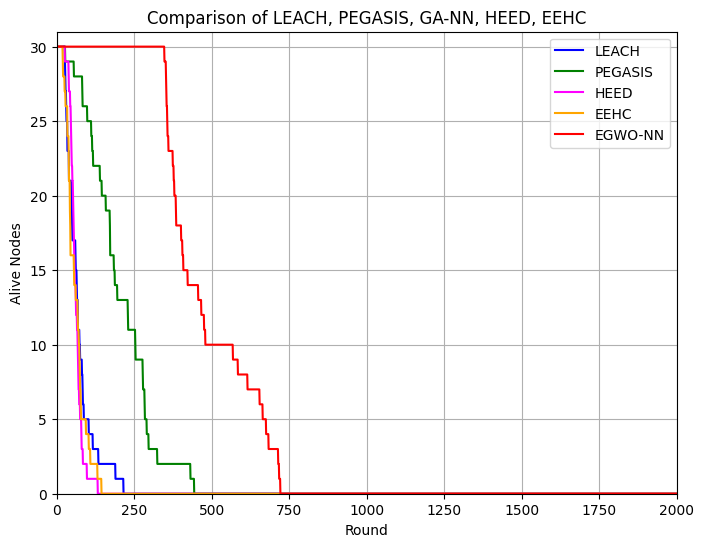

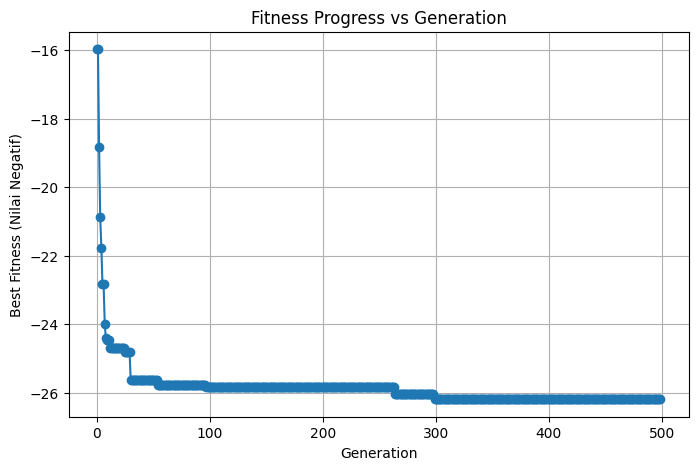

In [4]:
# Plot hasil
plt.figure(figsize=(8,6))
plt.plot(res_leach['round'], res_leach['alive'], label="LEACH", color='blue')
plt.plot(res_peg['round'],   res_peg['alive'],   label="PEGASIS", color='green')
plt.plot(res_heed['round'],  res_heed['alive'],  label="HEED", color='magenta')
plt.plot(res_eehc['round'],  res_eehc['alive'],  label="EEHC", color='orange')
plt.plot(sim_result['round'], sim_result['alive'], label="EGWO-NN", color='red')

plt.xlim(0, NUM_ROUNDS)
plt.ylim(0, NUM_NODES+1)
plt.xlabel("Round")
plt.ylabel("Alive Nodes")
plt.title("Comparison of LEACH, PEGASIS, GA-NN, HEED, EEHC")
plt.legend()
plt.grid(True)
plt.show()

# =========================================
# Menampilkan Grafik Fitness Progress vs Generation
# =========================================
plt.figure(figsize=(8, 5))
plt.plot(range(len(progress)), progress, marker='o', linestyle='-')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Nilai Negatif)')
plt.title('Fitness Progress vs Generation')
plt.grid(True)
plt.show()

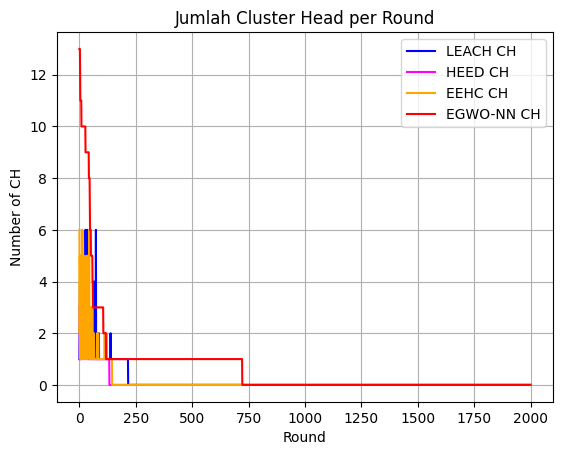

In [6]:
plt.figure()
plt.plot(res_leach['round'], res_leach['ch_count'], label='LEACH CH', color='blue')
plt.plot(res_heed['round'], res_heed['ch_count'], label="HEED CH", color='magenta')
plt.plot(res_eehc['round'], res_eehc['ch_count'], label="EEHC CH", color='orange')
plt.plot(sim_result['round'], sim_result['ch_count'], label='EGWO-NN CH', color='red')
plt.xlabel('Round')
plt.ylabel('Number of CH')
plt.title('Jumlah Cluster Head per Round')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
best_chrom

array([-0.14876062, -0.56240642,  0.84853774,  0.01076424,  0.9433275 ,
       -0.0472649 , -0.52485715,  0.30079381, -0.00505913, -1.        ,
       -0.06853561,  0.75243578])